In [1]:
import math
import numpy as np
import numpy.random as npr
from pylab import plt, mpl
import pandas as pd
from scipy.stats import norm

import seaborn as sns
sns.set_style('whitegrid')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [2]:
# Monte Carlo simulation of call/put option prices via geometric Brownian motion of the underlying stock price

"""
Inputs: 

S = spot price of the underlying stock

K = strike price

T = time to expiration

sigma = volatility of the option

r = risk-free interest rate

"""

# Call option
def MCS_call_price(S, K, T, sigma, r, I): # I is the number of simulations
    payoff = np.zeros((I, 2))
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * npr.standard_normal(I)) # formula of the geometric Brownian motion
    payoff[:,0] = ST - K 
    average = np.sum(np.amax(payoff, axis=1)) / float(I) # take maximum along each row max{S(T)-K, 0} to get the payoff at time T
                                                         # then calculate the average over all simulations 
    return np.exp(-r * T) * average # discount it by the interest rate

# Put option
def MCS_put_price(S,K,T,sigma,r,I): 
    payoff = np.zeros((I, 2))
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * npr.standard_normal(I)) 
    payoff[:,0] = K - ST 
    average = np.sum(np.amax(payoff, axis=1)) / float(I)
    
    return np.exp(-r * T) * average


In [3]:
# We will compare the Monte Carlo simulation to the Black-Scholes-Merton model

# Recall the formula of Black-Scholes-Merton for European call/put options (see, e.g., John Hull's book): 

def BSM_call_price(S, K, T, sigma, r): 
    d1 = (np.log(S/K) + (r + ((sigma**2)/2)) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    return C
    
def BSM_put_price(S,K,T,sigma,r): 
    d1 = (np.log(S/K) + (r + ((sigma**2)/2)) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    P = -S * norm.cdf(-d1) + K * np.exp(-r * T) * norm.cdf(-d2)
    
    return P

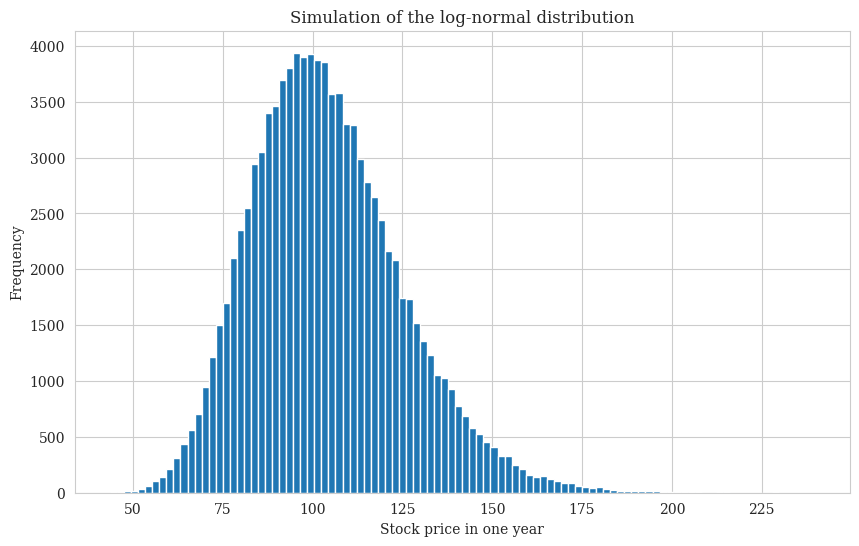

In [4]:
# Simulation of the underlying stock price

S0 = 100
sigma = 0.2
r = 0.04
T = 1.0

I = 100000
M = 100 # number of time steps

delta_t = T/M 

S = np.zeros((M+1, I))
S[0] = S0
for t in range(1,M+1):
    S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * npr.standard_normal(I))

plt.figure(figsize=(10, 6))
plt.hist(S[-1], bins=100)
plt.xlabel('Stock price in one year')
plt.ylabel('Frequency')
plt.title('Simulation of the log-normal distribution')
plt.show()


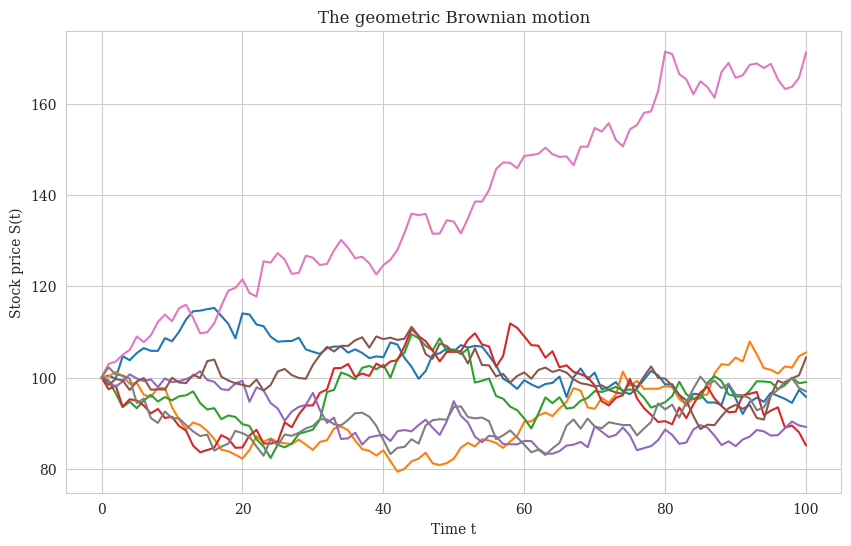

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(S[:, :8])
plt.xlabel('Time t')
plt.ylabel('Stock price S(t)')
plt.title('The geometric Brownian motion')
plt.show()

In [6]:
# Comparison

print('Monte Carlo:',MCS_call_price(100, 95, 1, 0.2, 0.03, 100000))
print('Black-Scholes: ',BSM_call_price(100, 95, 1, 0.2, 0.03))

Monte Carlo: 12.18810214718403
Black-Scholes:  12.1797020417631


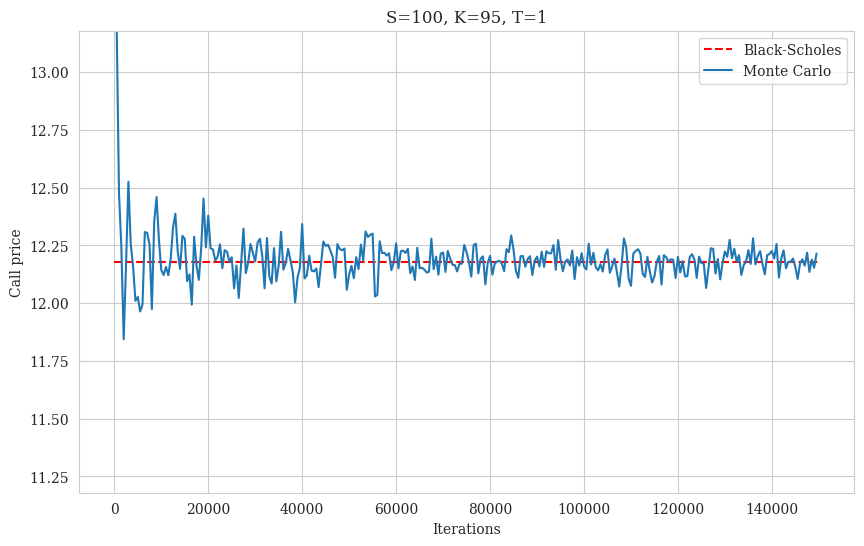

In [7]:
# Convergence

simul_list = []
mcs_list = []
for i in range(10, 150000, 500):
    simul_list.append(i)
    mcs_list.append(MCS_call_price(100, 95, 1, 0.2, 0.03, i))

simul_array = np.array(simul_list)
mcs_array = np.array(mcs_list)
data_array = np.concatenate(([simul_array], [mcs_array]), axis=0).T
df = pd.DataFrame(data_array, columns=['#Simul', 'MCS'])


plt.figure(figsize=(10,6))
plt.hlines(BSM_call_price(100, 95, 1, 0.2, 0.03), xmin=0, xmax= 150000, linestyle='dashed', colors='red', label = 'Black-Scholes')
plt.plot(df.set_index('#Simul'), lw = 1.5, label = 'Monte Carlo')

plt.title('S=100, K=95, T=1')
plt.xlabel('Iterations')
plt.ylabel('Call price')
plt.ylim(BSM_call_price(100, 95, 1, 0.2, 0.03)-1, BSM_call_price(100, 95, 1, 0.2, 0.03)+1)
plt.legend()
plt.show()